# Packages

In [75]:
import pickle

# Importer les modèles LR et AR(1) et AR(p)

In [76]:
# ==========================================
# Chargement de tous les modèles + métadonnées (robuste joblib/pickle)
# ==========================================
import pickle
import joblib
import pandas as pd

def load_any(path):
    """Essaye d'abord joblib (si le fichier a été sauvé avec joblib), 
    sinon bascule sur pickle."""
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def try_read_meta(path):
    try:
        meta = pd.read_csv(path, index_col=0)
        # si une seule colonne, on la simplifie en Series
        if meta.shape[1] == 1:
            meta = meta.iloc[:, 0]
        return meta
    except Exception as e:
        print(f"⚠️ Impossible de lire {path} : {e}")
        return None

In [77]:
# --- Fichiers à charger ---
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"

LINREG_PKL    = "linear_regression.pkl"          # <-- sauvegardé avec joblib.dump(exp_results, ...)
LINREG_META   = "linear_regression_meta.csv"

In [78]:
# --------- Chargement AR(1) ---------
print("=== Chargement AR(1) ===")
ar1_model = load_any(AR1_LAST_PKL)
ar1_meta  = try_read_meta(AR1_LAST_META)
print("✅ Modèle AR(1) chargé.")

# --------- Chargement Régression Linéaire ---------
print("\n=== Chargement régression linéaire ===")
linreg_bundle = load_any(LINREG_PKL)   # exp_results (dict)
linreg_meta   = try_read_meta(LINREG_META)
print("✅ Régression linéaire chargée.")

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.

=== Chargement régression linéaire ===
✅ Régression linéaire chargée.


In [79]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ========= utilitaires communs =========
def _get(meta, key, default=None):
    if meta is None:
        return default
    if isinstance(meta, dict):
        return meta.get(key, default)
    if isinstance(meta, pd.Series):
        return meta.get(key, default)
    if isinstance(meta, pd.DataFrame) and key in meta.columns:
        return meta[key].iloc[0]
    return default

def _normalize_month_start(s):
    """
    Convertit des dates en début de mois (start-of-month).
    Compatible Series / DatetimeIndex / scalaires Timestamp/np.datetime64.
    """
    s = pd.to_datetime(s)
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    try:
        return s.to_period("M").to_timestamp(how="start")
    except Exception:
        return pd.to_datetime(s).astype("datetime64[M]")

# ================= AR(1) -> df_ar1 =================
def build_df_ar1(ar1_model, ar1_meta, h=12, min_train_n=36):
    eval_start = pd.to_datetime(_get(ar1_meta, "eval_start", "1983-01-01"))
    eval_end   = pd.to_datetime(_get(ar1_meta, "eval_end",   "1989-12-31"))

    if "df_stationary_train_unrate" in globals():
        from statsmodels.tsa.ar_model import AutoReg
        y = globals()["df_stationary_train_unrate"].squeeze().sort_index().astype(float).dropna()
        y.index = pd.DatetimeIndex(pd.to_datetime(y.index)).to_period("M").to_timestamp(how="start")
        y = y.asfreq("MS")

        rows = []
        last_t_end = y.index.max() - relativedelta(months=h)
        for t_end in y.index:
            if t_end > last_t_end:
                break
            y_tr = y.loc[:t_end].dropna()
            if len(y_tr) < min_train_n:
                continue
            ar1 = AutoReg(y_tr, lags=1, old_names=False).fit()
            fc = ar1.predict(start=len(y_tr), end=len(y_tr) + h - 1)
            yhat_h = float(fc.iloc[-1])
            t_fore = t_end + relativedelta(months=h)
            if t_fore in y.index:
                rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

        df = pd.DataFrame(rows, columns=["date", "true", "pred"]).sort_values("date")
        df["date"] = _normalize_month_start(df["date"])
        source = "OOS h=12 (expanding)"
    else:
        # fallback in-sample proxy
        try:
            y = pd.Series(ar1_model.model.endog)
        except Exception as e:
            raise RuntimeError(f"AR(1) : impossible de récupérer la série endog depuis le modèle: {e}")
        try:
            idx = ar1_model.model.data.row_labels
            if idx is not None and len(idx) == len(y):
                y.index = pd.Index(idx, name="date")
        except Exception:
            pass
        if not isinstance(y.index, pd.DatetimeIndex):
            y.index = pd.RangeIndex(len(y), name="date")

        start_pos, end_pos = 1, len(y) - 1
        pred = ar1_model.predict(start=start_pos, end=end_pos, dynamic=False)
        df = pd.DataFrame({
            "date": y.index[start_pos:end_pos + 1],
            "true": np.asarray(y.iloc[start_pos:end_pos + 1], dtype=float),
            "pred": np.asarray(pred, dtype=float)
        })
        if isinstance(df["date"].iloc[0], (np.datetime64, pd.Timestamp)):
            df["date"] = _normalize_month_start(df["date"])
            df = df[(df["date"] >= eval_start) & (df["date"] <= eval_end)]
        source = "one-step in-sample (proxy)"

    # enrichissement meta
    df["method"] = "AR1"
    df["hyper_type"]  = "none"
    df["features"]    = 1
    df["lag"]         = 1
    df["n_boot"]      = None
    df["winsorize"]   = None
    df["window_size"] = None

    # remettre un index simple
    df = df.reset_index(drop=True)

    print(f"✅ df_ar1 prêt — {source} — shape={df.shape}")
    return df

# ================= LinearRegression -> df_lin =================
def build_df_lin(linreg_bundle):
    oos = linreg_bundle["oos_predictions"].copy()
    if oos.index.name is not None:
        oos = oos.reset_index()

    cols = {c.lower(): c for c in oos.columns}
    date_col = cols.get("date") or cols.get("dates")
    true_col = cols.get("y_true") or cols.get("true")
    pred_col = cols.get("y_pred") or cols.get("pred") or cols.get("prediction")
    assert date_col and true_col and pred_col, f"Colonnes manquantes dans oos_predictions: {oos.columns.tolist()}"

    df = oos[[date_col, true_col, pred_col]].rename(columns={date_col: "date", true_col: "true", pred_col: "pred"})
    df["date"] = _normalize_month_start(df["date"])

    params = linreg_bundle.get("params", {}) or {}
    features = linreg_bundle.get("features", None)
    if isinstance(features, (list, tuple, set)):
        features = len(features)

    df["method"]      = "LinearRegression"
    df["hyper_type"]  = params.get("hyper_type", "kfold_block_gap")
    df["features"]    = features
    df["lag"]         = params.get("shift_lag", params.get("lag", None))
    df["n_boot"]      = params.get("n_boot", None)
    df["winsorize"]   = params.get("winsor_level", params.get("winsorize", None))
    df["window_size"] = params.get("window_size", None)

    # index remis à zéro aussi pour cohérence
    df = df.reset_index(drop=True)

    print(f"✅ df_lin prêt — from oos_predictions — shape={df.shape}")
    return df

# ======= Construire les 2 DataFrames =======
df_ar1 = build_df_ar1(ar1_model, ar1_meta, h=12, min_train_n=36)
df_lin = build_df_lin(linreg_bundle)

# (optionnel) affichage rapide
print("\nAperçu df_ar1:\n", df_ar1.head())
print("\nAperçu df_lin:\n", df_lin.head())

✅ df_ar1 prêt — one-step in-sample (proxy) — shape=(71, 10)
✅ df_lin prêt — from oos_predictions — shape=(83, 10)

Aperçu df_ar1:
         date  true      pred method hyper_type  features  lag n_boot  \
0 1983-01-01   1.8  2.216554    AR1       none         1    1   None   
1 1983-02-01   1.5  1.734915    AR1       none         1    1   None   
2 1983-03-01   1.3  1.445932    AR1       none         1    1   None   
3 1983-04-01   0.9  1.253276    AR1       none         1    1   None   
4 1983-05-01   0.7  0.867965    AR1       none         1    1   None   

  winsorize window_size  
0      None        None  
1      None        None  
2      None        None  
3      None        None  
4      None        None  

Aperçu df_lin:
         date  true      pred            method       hyper_type  features  \
0 1983-01-01   1.8  1.280911  LinearRegression  kfold_block_gap        10   
1 1983-02-01   1.5  2.113036  LinearRegression  kfold_block_gap        10   
2 1983-03-01   1.3  2.165873  Li

In [80]:
df_ar1.head()

,date,true,pred,method,hyper_type,features,lag,n_boot,winsorize,window_size
0,1983-01-01,1.8,2.216554,AR1,none,1,1,None,None,None
1,1983-02-01,1.5,1.734915,AR1,none,1,1,None,None,None
2,1983-03-01,1.3,1.445932,AR1,none,1,1,None,None,None
3,1983-04-01,0.9,1.253276,AR1,none,1,1,None,None,None
4,1983-05-01,0.7,0.867965,AR1,none,1,1,None,None,None


In [81]:
df_lin.head()

,date,true,pred,method,hyper_type,features,lag,n_boot,winsorize,window_size
0,1983-01-01,1.8,1.280911,LinearRegression,kfold_block_gap,10,12,None,0.01,None
1,1983-02-01,1.5,2.113036,LinearRegression,kfold_block_gap,10,12,None,0.01,None
2,1983-03-01,1.3,2.165873,LinearRegression,kfold_block_gap,10,12,None,0.01,None
3,1983-04-01,0.9,1.349844,LinearRegression,kfold_block_gap,10,12,None,0.01,None
4,1983-05-01,0.7,1.052480,LinearRegression,kfold_block_gap,10,12,None,0.01,None


In [82]:
import pandas as pd

# ========= Fusion des deux modèles en format long =========

# On concatène les deux DataFrames (AR1 et LinearRegression)
df_pred_long = pd.concat([df_ar1, df_lin], ignore_index=True)

# Conversion et tri
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"])
df_pred_long = df_pred_long.sort_values(["date", "method"]).reset_index(drop=True)

# Supprimer les colonnes inutiles
cols_to_drop = ["hyper_type", "features", "lag", "n_boot", "winsorize", "window_size"]
df_pred_long = df_pred_long.drop(columns=[c for c in cols_to_drop if c in df_pred_long.columns])

print(f"✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
print("Colonnes restantes :", df_pred_long.columns.tolist())
print("Méthodes présentes :", df_pred_long["method"].unique().tolist())

# Aperçu du contenu
print("\nAperçu des premières lignes :")
print(df_pred_long.head(10))

✅ Fusion réussie — df_pred_long shape = (154, 4)
Colonnes restantes : ['date', 'true', 'pred', 'method']
Méthodes présentes : ['AR1', 'LinearRegression']

Aperçu des premières lignes :
        date  true      pred            method
0 1983-01-01   1.8  2.216554               AR1
1 1983-01-01   1.8  1.280911  LinearRegression
2 1983-02-01   1.5  1.734915               AR1
3 1983-02-01   1.5  2.113036  LinearRegression
4 1983-03-01   1.3  1.445932               AR1
5 1983-03-01   1.3  2.165873  LinearRegression
6 1983-04-01   0.9  1.253276               AR1
7 1983-04-01   0.9  1.349844  LinearRegression
8 1983-05-01   0.7  0.867965               AR1
9 1983-05-01   0.7  1.052480  LinearRegression


C:\Users\Mita\AppData\Local\Temp\ipykernel_16148\1310085801.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_long = pd.concat([df_ar1, df_lin], ignore_index=True)


# Test

C:\Users\Mita\AppData\Local\Temp\ipykernel_16148\694678648.py:40: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


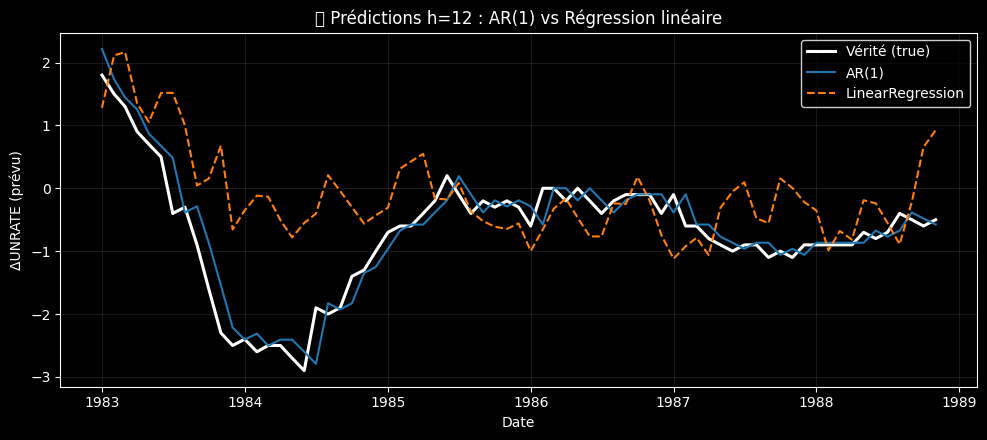

C:\Users\Mita\AppData\Local\Temp\ipykernel_16148\694678648.py:57: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mita\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


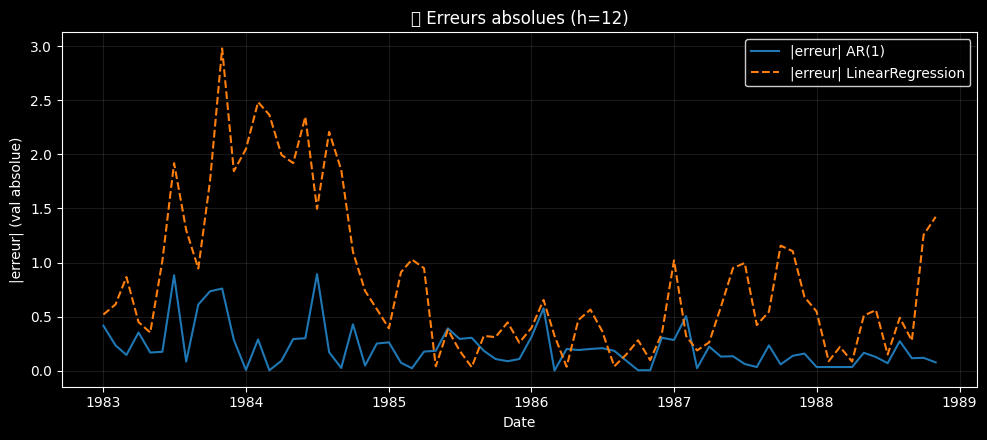

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Préparation des données ===
dfl = df_pred_long.copy()
dfl["date"] = pd.to_datetime(dfl["date"])
dfl = dfl.sort_values(["date", "method"])

wide = dfl.pivot(index="date", columns="method", values="pred")
ytrue = dfl.drop_duplicates("date").set_index("date")["true"]
wide = wide.join(ytrue.rename("true")).dropna()

# === Style fond noir ===
plt.style.use("dark_background")

# Couleurs cohérentes
colors = {
    "AR1": "#1f77b4",              # bleu vif
    "LinearRegression": "#ff7f0e", # orange chaud
    "true": "#ffffff"              # blanc pour la vérité
}

# === 1️⃣ Prédictions vs Vérité ===
plt.figure(figsize=(10, 4.5))
plt.plot(wide.index, wide["true"], label="Vérité (true)",
         color=colors["true"], linewidth=2.2)
if "AR1" in wide:
    plt.plot(wide.index, wide["AR1"], label="AR(1)",
             color=colors["AR1"], linestyle='-')
if "LinearRegression" in wide:
    plt.plot(wide.index, wide["LinearRegression"], label="LinearRegression",
             color=colors["LinearRegression"], linestyle='--')

plt.title("🔹 Prédictions h=12 : AR(1) vs Régression linéaire", color="white", fontsize=12)
plt.xlabel("Date", color="white")
plt.ylabel("ΔUNRATE (prévu)", color="white")
plt.legend(facecolor="black", edgecolor="white")
plt.grid(alpha=0.2, color="gray")
plt.tight_layout()
plt.show()

# === 2️⃣ Erreurs absolues ===
plt.figure(figsize=(10, 4.5))
if "AR1" in wide:
    plt.plot(wide.index, np.abs(wide["true"] - wide["AR1"]),
             label="|erreur| AR(1)", color=colors["AR1"], linestyle='-')
if "LinearRegression" in wide:
    plt.plot(wide.index, np.abs(wide["true"] - wide["LinearRegression"]),
             label="|erreur| LinearRegression", color=colors["LinearRegression"], linestyle='--')

plt.title("🔸 Erreurs absolues (h=12)", color="white", fontsize=12)
plt.xlabel("Date", color="white")
plt.ylabel("|erreur| (val absolue)", color="white")
plt.legend(facecolor="black", edgecolor="white")
plt.grid(alpha=0.2, color="gray")
plt.tight_layout()
plt.show()

In [88]:
import numpy as np
import pandas as pd
from math import erf, sqrt

# --- (optionnel) éviter le FutureWarning au concat (si tu le refais plus tard)
# df_pred_long = pd.concat([d for d in [df_ar1, df_lin] if d is not None and not d.empty], ignore_index=True)

# Assurer types & tri
df_pred_long = df_pred_long.copy()
df_pred_long["date"] = pd.to_datetime(df_pred_long["date"])
df_pred_long = df_pred_long.sort_values(["date","method"]).reset_index(drop=True)

# 1) Métriques par modèle (sans FutureWarning de groupby.apply)
def _metrics(y_true, y_pred):
    e = np.asarray(y_pred, float) - np.asarray(y_true, float)
    mae  = np.mean(np.abs(e))
    rmse = np.sqrt(np.mean(e**2))
    bias = np.mean(e)
    ssr, sst = np.sum(e**2), np.sum((np.asarray(y_true,float)-np.mean(y_true))**2)
    r2 = 1 - ssr/sst if sst > 0 else np.nan
    return pd.Series({"MAE":mae, "RMSE":rmse, "Bias":bias, "R2":r2})

metrics = (df_pred_long.groupby("method")[["true","pred"]]
           .apply(lambda g: _metrics(g["true"], g["pred"]))
           .reset_index())

print("=== Métriques par modèle ===")
print(metrics.to_string(index=False))

# 2) Test de Diebold–Mariano (h=12, perte quadratique)
def _nw_var(d, lag):
    d = np.asarray(d, float); d = d - d.mean()
    T = len(d)
    if T == 0: return np.nan
    var = np.dot(d,d)/T
    for l in range(1, lag+1):
        cov = np.dot(d[l:], d[:-l]) / T
        var += 2*(1 - l/(lag+1))*cov
    return var

def dm_test(y, y1, y2, h=12, power=2, alternative="two_sided"):
    e1, e2 = y - y1, y - y2
    l1 = np.abs(e1) if power==1 else e1**2
    l2 = np.abs(e2) if power==1 else e2**2
    d  = l1 - l2
    d_bar = d.mean()
    var_d = _nw_var(d, lag=max(h-1,0))
    if not np.isfinite(var_d) or var_d==0: return np.nan, np.nan
    DM = d_bar / np.sqrt(var_d/len(d))
    cdf = lambda x: 0.5*(1+erf(x/np.sqrt(2)))
    p = 2*(1-cdf(abs(DM))) if alternative=="two_sided" else (cdf(DM) if alternative=="less" else 1-cdf(DM))
    return float(DM), float(p)

# Aligner AR1 et LR sur les mêmes dates
wide = (df_pred_long.pivot(index="date", columns="method", values="pred")
        .join(df_pred_long.drop_duplicates("date")[["date","true"]].set_index("date"))
        .dropna(subset=["true","AR1","LinearRegression"])
        .sort_index())

DM, p = dm_test(wide["true"].values,
                wide["LinearRegression"].values,
                wide["AR1"].values,
                h=12, power=2, alternative="two_sided")

print("\n=== Diebold–Mariano (LR vs AR1, h=12) ===")
print(f"DM = {DM},  p-value = {p}")

=== Métriques par modèle ===
          method      MAE     RMSE     Bias        R2
             AR1 0.214145 0.292867 0.064968  0.902730
LinearRegression 0.737050 1.009179 0.534018 -0.299573

=== Diebold–Mariano (LR vs AR1, h=12) ===
DM = 2.0696160875361524,  p-value = 0.038488310329823916


➡️ AR(1) est nettement plus performant à l’horizon 
ℎ = 12

Et le test Diebold–Mariano (DM = 2.07, p = 0.038) indique :
- La différence de performance entre les deux modèles est statistiquement significative au seuil de 5 %.

Autrement dit :
- AR(1) prédit significativement mieux que la régression linéaire pour ton horizon 12 mois.
- La Régression linéaire n'a donc pas fait mieux que notre baseline en termes de prévision. 